# PART B - Transfer Learning

For many natural language processing tasks, it is generally not a good idea to train a very large deep neural network model from scratch due to enormous compute requirements and lack of sufficient amounts of training data. Instead, you should always try to take advantage of an existing model that performs similar tasks as the one you need to solve.

In this part of the assignment we will be using pretrained models to improve the performance on identifying positive and negative reviews. There are several pretrained models that are available to us, here we will use a pretrained BERT model that comes with the hugging face transformer library.

Provided below is sample code to get you started. For more details please visit the hugging face tutorial on using pretrained models using PyTorch: https://huggingface.co/docs/transformers/training

#### Sample Code

In [4]:
# load relevant libraries
import transformers
import torch
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)


/Users/aordorica/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
sample_txt = 'I want to learn how to do sentiment analysis using BERT and tokenizer.'

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
  truncation = True
)

/Users/aordorica/miniforge3/envs/pytorch_env/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [6]:
encoding['input_ids']

tensor([[  101,   146,  1328,  1106,  3858,  1293,  1106,  1202, 17024,  3622,
          1606,   139,  9637,  1942,  1105, 22559, 17260,   119,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])

In [7]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [8]:
hidden_states = bert_model(input_ids=encoding['input_ids'],
                           attention_mask=encoding['attention_mask'])[0]
pooled_output = bert_model(input_ids=encoding['input_ids'],
                           attention_mask=encoding['attention_mask'])[1]

In [9]:
hidden_size = bert_model.config.hidden_size

print(hidden_size)
print(hidden_states.shape)
print(pooled_output.shape)


768
torch.Size([1, 32, 768])
torch.Size([1, 768])


In the sample code provided we loaded a short text sequence, tokenized it using the same tokenization that was used in the pretrained BERT model, and fed the tokenized input into the BERT model to obtain the embeddings.

The model output consists of two forms of embeddings:
- **hidden_states** are the final layer of outputs that has a shape sequence_length x embeddings, much like the hidden states of a recurrent neural network
- **pooled_output** is the result of applying max pooling on the hidden states to effectively collapse the sequence dimenension and ensure the same output size for any given sequence before feeding into the classification stage

Note that you can preprocess all of the data prior to training a classifier stage for sentiment analysis to help speed up the training process. This is no different from the process we applied in an earlier assignment using AlexNet and image data.

## Part 1. Data Loading [5 pt]

We will be using the same "IMDB Movie Review Dataset" that we used earlier. Reload the data and complete Part B of the assignment. You should be able to complete part B independently from Part A.

### Part (i) [1pt EXPLORATORY] - create train/test/val dataloaders

Provided below is a DataLoader for your training and test datasets so you can iterate over batches of data. Run the DataLoader to create your training, validation, and test data.

In [11]:
from datasets import ReviewDataset, MovieReviewDatasetB
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

# download IMDB review data

# load dataset
df = pd.read_csv("IMDB Dataset.csv")

# process into data and labels
X = df['review'].values
y = df['sentiment'].values

# Assigning a random number between 0 and 1 to each row in the DataFrame
df['random_number'] = np.random.rand(df.shape[0])
df.head()

,review,sentiment,random_number
0,One of the other reviewers has mentioned that ...,positive,0.106966
1,A wonderful little production. <br /><br />The...,positive,0.201972
2,I thought this was a wonderful way to spend ti...,positive,0.548553
3,Basically there's a family where a little boy ...,negative,0.212986
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,0.582670


In [12]:
# Splitting the dataset based on the random number for a 60-20-20 split
train_df = df[df['random_number'] <= 0.6]
val_df = df[(df['random_number'] > 0.6) & (df['random_number'] <= 0.8)]
test_df = df[df['random_number'] > 0.8]

# You can now drop the 'random_number' column if it's no longer needed
train_df = train_df.drop('random_number', axis=1)
val_df = val_df.drop('random_number', axis=1)
test_df = test_df.drop('random_number', axis=1)

# The datasets are now split into train (60%), validation (20%), and test (20%) sets
# train_df, val_df, test_df

In [13]:


# Prepare data loaders
MAX_LEN = 400
BATCH_SIZE = 16

train_data = MovieReviewDatasetB(reviews=train_df['review'].to_numpy(),
                              targets=train_df['sentiment'].to_numpy(),
                              tokenizer=tokenizer,
                              max_len=MAX_LEN)

train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, num_workers=0)  # modify num_workers as needed


val_data = MovieReviewDatasetB(reviews=val_df['review'].to_numpy(),
                              targets=val_df['sentiment'].to_numpy(),
                              tokenizer=tokenizer,
                              max_len=MAX_LEN)

val_data_loader = DataLoader(val_data, batch_size=BATCH_SIZE, num_workers=0)  # modify num_workers as needed

# Test data
test_data = MovieReviewDatasetB(reviews=test_df['review'].to_numpy(),
                               targets=test_df['sentiment'].to_numpy(),
                               tokenizer=tokenizer,
                               max_len=MAX_LEN)

test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=0)  # modify num_workers as needed


### Part (ii) [1pt EXPLORATORY] - load one sample with `train_data_loader`

Use the **train_data_loader** to load one sample. What are the different attributes provided with the sample and how are they used?

In [14]:
# Load a single batch from the DataLoader
for batch in train_data_loader:
    # We'll just look at the first batch and then break out of the loop
    break

# The reviews in text form
reviews = batch['review_text']
print("Reviews:", reviews)

# The input IDs from the tokenizer
input_ids = batch['input_ids']
print("Input IDs:", input_ids)

# The attention masks from the tokenizer
attention_masks = batch['attention_mask']
print("Attention Masks:", attention_masks)

# The target labels (sentiments)
targets = batch['targets']
print("Targets:", targets)


Reviews: ["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due

### Part (iii) [1pt EXPLORATORY]

Determine the range of values for the tokens in the training data. How are the tokens obtained?

Hint: You can apply your intuition here, or do some additional research to find how the "bert-base-cased" tokenization is done.

In [15]:
import data_utils

# Assuming your train_data_loader is already defined
min_token_value, max_token_value = data_utils.find_token_range(train_data_loader)

print(f"Minimum token value: {min_token_value}")
print(f"Maximum token value: {max_token_value}")


Processing batch 0/1877 in find_token_range
Processing batch 100/1877 in find_token_range
Processing batch 200/1877 in find_token_range
Processing batch 300/1877 in find_token_range
Processing batch 400/1877 in find_token_range
Processing batch 500/1877 in find_token_range
Processing batch 600/1877 in find_token_range
Processing batch 700/1877 in find_token_range
Processing batch 800/1877 in find_token_range
Processing batch 900/1877 in find_token_range
Processing batch 1000/1877 in find_token_range
Processing batch 1100/1877 in find_token_range
Processing batch 1200/1877 in find_token_range
Processing batch 1300/1877 in find_token_range
Processing batch 1400/1877 in find_token_range
Processing batch 1500/1877 in find_token_range
Processing batch 1600/1877 in find_token_range
Processing batch 1700/1877 in find_token_range
Processing batch 1800/1877 in find_token_range
Minimum token value: 0
Maximum token value: 28209


In [16]:
print("Tokenizer vocabulary size:", len(tokenizer.vocab))

Tokenizer vocabulary size: 28996


In [17]:
print(transformers.__version__)

4.36.0.dev0


In [18]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, force_download=True)
print("Tokenizer vocabulary size after re-downloading:", len(tokenizer.vocab))

Tokenizer vocabulary size after re-downloading: 28996


### Part (iv) [1pt EXPLORATORY]

Generate histograms of all the token values in the training data. Repeat for the validation and test data. What are the top 5 occuring tokens in the training_dataset? What do these tokens represent?

In [19]:
# Assuming train_data_loader, val_data_loader, test_data_loader are defined
train_tokens = data_utils.collect_tokens(train_data_loader)
val_tokens = data_utils.collect_tokens(val_data_loader)
test_tokens = data_utils.collect_tokens(test_data_loader)

# Create histograms
train_histogram = data_utils.create_histogram(train_tokens, 'Training Data Token Histogram')
val_histogram = data_utils.create_histogram(val_tokens, 'Validation Data Token Histogram')
test_histogram = data_utils.create_histogram(test_tokens, 'Test Data Token Histogram')

# Count tokens (if needed)
train_token_counts = data_utils.count_tokens(train_data_loader)

Processing batch 0/1877 in collect_tokens
Processing batch 100/1877 in collect_tokens
Processing batch 200/1877 in collect_tokens
Processing batch 300/1877 in collect_tokens
Processing batch 400/1877 in collect_tokens
Processing batch 500/1877 in collect_tokens
Processing batch 600/1877 in collect_tokens
Processing batch 700/1877 in collect_tokens
Processing batch 800/1877 in collect_tokens
Processing batch 900/1877 in collect_tokens
Processing batch 1000/1877 in collect_tokens
Processing batch 1100/1877 in collect_tokens
Processing batch 1200/1877 in collect_tokens
Processing batch 1300/1877 in collect_tokens
Processing batch 1400/1877 in collect_tokens
Processing batch 1500/1877 in collect_tokens
Processing batch 1600/1877 in collect_tokens
Processing batch 1700/1877 in collect_tokens
Processing batch 1800/1877 in collect_tokens
Processing batch 0/625 in collect_tokens
Processing batch 100/625 in collect_tokens
Processing batch 200/625 in collect_tokens
Processing batch 300/625 in co

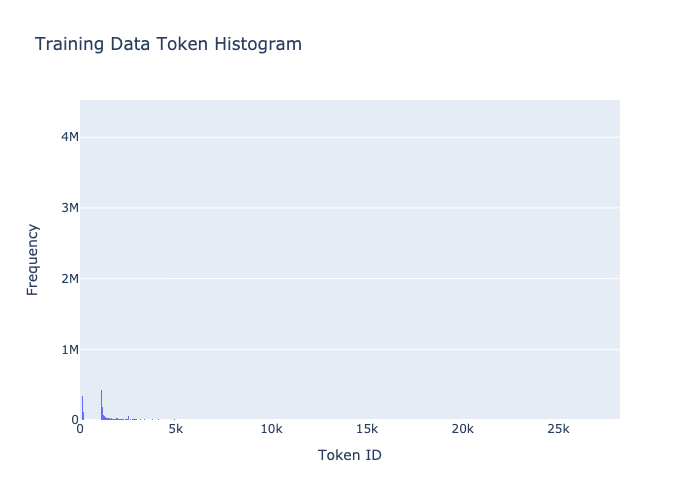

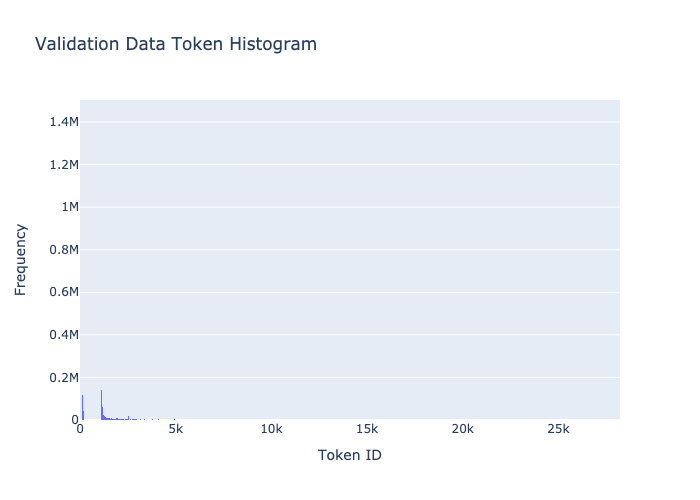

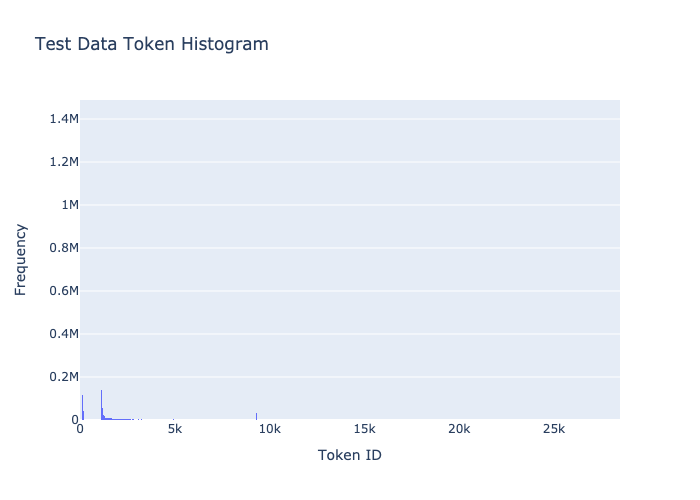

In [20]:
# Show histograms
train_histogram.show()
val_histogram.show()
test_histogram.show()

In [22]:
train_histogram.write_html('train_histogram.html')
val_histogram.write_html('val_histogram.html')
test_histogram.write_html('test_histogram.html')


In [23]:
break 

SyntaxError: 'break' outside loop (371449011.py, line 1)

####  Count Token Frequencies

In [ ]:


# Count tokens in the training dataset
train_token_counts = count_tokens(train_data_loader)
val_token_counts = count_tokens(val_data_loader)


####  Identify Top 5 Tokens

In [ ]:
# Get the top 5 tokens
train_top_5_tokens = train_token_counts.most_common(5)
print("Top 5 tokens train:", train_top_5_tokens)


In [ ]:
# Get the top 5 tokens
val_top_5_tokens = val_token_counts.most_common(5)
print("Top 5 tokens:", val_top_5_tokens)

#### Translate Tokens to Words

In [ ]:
# Translate tokens to words
train_top_5_words = [(tokenizer.convert_ids_to_tokens(token_id), count) for token_id, count in train_top_5_tokens]
print("Top 5 tokens and their corresponding words:", train_top_5_words)


In [ ]:
# Translate tokens to words
val_top_5_words = [(tokenizer.convert_ids_to_tokens(token_id), count) for token_id, count in val_top_5_tokens]
print("Top 5 tokens and their corresponding words:", val_top_5_words)

### Part (v) [1pt EXPLORATORY] - `hidden_states` and `pooled_output`

Select a single sample from your training DataLoader and feed it through the **bert_model** to obtain the hidden_states and pooled_output. Briefly describe what each tensor dimension represents and what affects the size of each dimension.

#### 1: Extracting a Single Batch

In [ ]:
# Extract a single batch from the DataLoader
batch = next(iter(train_data_loader))

# Select the first sample from the batch
input_ids = batch['input_ids'][0].unsqueeze(0)  # Add batch dimension
attention_mask = batch['attention_mask'][0].unsqueeze(0)  # Add batch dimension


#### 2. Feeding the input into the BERT model 

In [ ]:
bert_model.eval()

with torch.no_grad():
    # Feed input to BERT
    outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)

    # Extract hidden states and pooled output
    hidden_states = outputs.last_hidden_state
    pooled_output = outputs.pooler_output


#### Input IDs (input_ids)

* Dimension: `[batch_size, sequence_length]`
* Description: Each element in input_ids is a list of token IDs, which are numerical representations of tokens.
* What Affects Size:
    * batch_size: Determined by how many samples you process at a time. In this case, because it's only one sample, it's 1.
    * sequence_length: The length of the tokenized input sequence. It's affected by the max_length parameter during tokenization.

In [ ]:
print("Input IDs Dimension:", input_ids.shape)

#### Attention Mask (attention_mask)
* Dimension: `[batch_size, sequence_length]`
* Description: This mask indicates to the model which tokens should be attended to and which should not (like padding tokens).
* What Affects Size:
    * batch_size: Same as in input_ids.
    * sequence_length: Same as in input_ids.

In [ ]:
print("Attention Mask Dimension:", attention_mask.shape)


#### Hidden States (hidden_states from BERT Output):
* Dimension: `[batch_size, sequence_length, hidden_size]`
* Description: The output of the BERT model for each token in the sequence for each sample in the batch.
* What Affects Size:
* batch_size: Same as above.
* sequence_length: Same as above.
* hidden_size: Determined by the BERT model configuration. For bert-base-cased, it's typically 768.

In [ ]:
print("Hidden States Dimension:", hidden_states.shape)

#### Pooled Output (pooled_output from BERT Output):
* Dimension: `[batch_size, hidden_size]`
* Description: A summary of the input sequence, typically used for classification tasks. It's derived from the hidden state of the [CLS] token.
* What Affects Size:
    * batch_size: Same as above.
    * hidden_size: Same as in hidden_states.

In [ ]:
print("Pooled Output Dimension:", pooled_output.shape)

## Part 2. Model Architecture [2 pt]

### Part (i) [1pt MODEL] - SentimentClassifierPooled class

Prepare a review classifier model that builds on the pooled output from the Bert model to identify positive and negative reviews.

In [ ]:
from torch import nn
from transformers import BertModel

class SentimentClassifierPooled(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifierPooled, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(p=0.3)

        # Linear layer to map the pooled output to the number of classes
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        # Getting pooled output from BERT
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)

        # Applying dropout
        output = self.dropout(pooled_output)

        # Passing through the linear layer
        return self.out(output)


### Part (ii) [1pt MODEL] - SentimentClassifierLast class

Construct the architecture for a review classifier model that uses the last hidden output from the Bert model to identify positive and negative reviews.

In [ ]:
# class SentimentClassifierLast(nn.Module):

#   def __init__(self, n_classes):
#     super(SentimentClassifierLast, self).__init__()
#     self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

#     # TO BE COMPLETED

#   def forward(self, input_ids, attention_mask):

#     # TO BE COMPLETED


from torch import nn
from transformers import BertModel

class SentimentClassifierLast(nn.Module):
    def __init__(self):
        super(SentimentClassifierLast, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(p=0.3)

        # Linear layer to map the last hidden state of the [CLS] token to a single output
        self.out = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        # Getting the last hidden state output
        last_hidden_state = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state

        # Extract the [CLS] token's embeddings
        cls_token_embedding = last_hidden_state[:, 0, :]

        # Applying dropout
        dropout_output = self.dropout(cls_token_embedding)

        # Passing through the linear layer and applying sigmoid
        return torch.sigmoid(self.out(dropout_output))


## Part 3. Training [3 pt]

### Part (i) [1pt MODEL] - get accuracy function

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).

In [ ]:
# def get_accuracy(model, data):
#     """ Compute the accuracy of the `model` across a dataset `data`

#     Example usage:

#     >>> model = MyRNN() # to be defined
#     >>> get_accuracy(model, valid_loader) # the variable `valid_loader` is from above
#     """

#     # TO BE COMPLETED

def get_accuracy(model, data_loader):
    """ Compute the accuracy of the `model` across a dataset `data_loader` """
    model.eval()  # Set the model to evaluation mode

    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Disable gradient calculations
        for batch in data_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            targets = batch['targets']

            # Get model predictions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Get the predicted class (the one with the highest probability)
            preds = torch.argmax(outputs, dim=1)

            # Count correct predictions
            correct_predictions += torch.sum(preds == targets)
            total_predictions += targets.size(0)

    # Calculate accuracy
    accuracy = correct_predictions.double() / total_predictions
    return accuracy.item()



### Part (ii) [1pt MODEL]

Write a function **train_model** to train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

In [ ]:
model = SentimentClassifierLast()  # No need to pass n_classes for binary classification
if torch.backends.mps.is_available():
    model.to("mps")


In [ ]:
from train_utils import train_model

import importlib
import train_utils

# Reload the module
importlib.reload(train_utils)

# Now import the function again
from train_utils import train_model, log_training_results, plot_training_curves, get_accuracy

In [ ]:
results = train_model(
    model=model,
    train_loader=train_data_loader,
    val_loader=val_data_loader,
    criterion_func=nn.BCEWithLogitsLoss,
    epochs=1,
    learning_rate=0.001,
    weight_decay=1e-5,
    use_clipping=True,
    clip_value=1.0
)

In [ ]:
from train_utils import train_model, log_training_results, plot_training_curves
# Assuming results contain the output from train_model
log_training_results('training_log_bert_partB3ii.csv', results)


In [ ]:
plot_training_curves('training_log_bert_partB3ii.csv')

### Part (iii) [1pt MODEL]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters. You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [ ]:
# TO BE COMPLETED





In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

## Part 4. Evaluation [10 pt]

### Part (i) [3pt RESULT]

Report the final test accuracy of your best BERT-based model. Then summarize in a pandas dataframe the accuracy obtained on the training, validation, and test data of your best models from Part A and B.

How does the BERT model compare to the approach in part A using only LSTM? Are the results what you expected? Explain.



In [ ]:
# TO BE COMPLETED





In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Part (ii) [2pt RESULT]

Report the false positive rate and false negative rate of your model across the test set. Then summarize in a pandas dataframe the false postive and false negative rate of your model obtained on the training, validation, and test data of your best models from Part A and B.

How does the BERT model compare to the approach in part A using only LSTM? Are the results what you expected? Explain.

In [ ]:
# TO BE COMPLETED




In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Part (iii) [3pt DISCUSSION]
Examine some of the misclassified reviews from you best BERT and LSTM models to better identify the differences in the models. Try to provide some justification for any differences in the misclassifications observed in the models.

Is there any part of the review that you could modify to make the classifications correct? Try to make small changes to the review to see if you can make the model make the correct classification while keeping the review as close to the original as possible.

In [ ]:
# TO BE COMPLETED





In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Part (iv) [2pt DISCUSSION]
Find 5 samples of positive and negative reviews on IMDB that were posted recently and evaluate them with your best BERT and LSTM models from parts A and B. How well do they perform?

In [ ]:
# TO BE COMPLETED





In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

# PART C (Optional) - Bonus Challenge!

This is an optional exercise for those that finish the assignment early and would like to take on a challenging task.

In part A we constructed and trained an LSTM model to identify the sentiment in movie reviews. In Part B we used the embeddings of a BERT model pretrained on a large corpus of text to demonstrate how transfer learning can be used to improve our movie sentiment model. The BERT model is one of many language models that we could have used to implement transfer learning.

For this bonus challenge you are asked to implement a generative character-level LSTM model to produce IMDB movie reviews. Once the model is sufficiently trained you can then use its hidden states as the embedding for training a movie sentiment model. Construct your new movie sentiment analysis model and compare the performance against the model from part A and B.

There are many variants of a generative LSTM model that you can consider. As a starting point you can use the generative LSTM sample code provided in the lecture notes. Specifically, the one used to generate Shakeaspeare. More advanced versions of a generative LSTM can be found in the Universal Language Model Fine-turing for Text Classification (ULMfit) paper (https://arxiv.org/abs/1801.06146).

Tasks:

1. Create a generative character-level LSTM model trained to create IMDB reviews
2. Create a classifier using the embeddings from the generative LSTM model (from step 1) to identify positive and negative reviews.
3. Compare the performance of the model with the results in parts A and B of the assignment.
4. Upgrade the generative LSTM model using the techniques listed in the ULMfit paper (e.g., bi-directional LSTM, pretraining with wikipedia text and fine-tuning on IMDBT reviews, etc.).

Bonus marks will be provided based on the number of steps completed. Summarize below your results and anything intersting you learned from the steps that you completed. Bonus marks cannot be accumulated beyond a maximum assignment grade.


In [ ]:
# TO BE COMPLETED




In [ ]:
'''
PROVIDE YOUR ANSWER BELOW






'''

### Saving to HTML
Detailed instructions for saving to HTML can be found <a href="https://stackoverflow.com/questions/53460051/convert-ipynb-notebook-to-html-in-google-colab/64487858#64487858">here</a>. Provided below are a summary of the instructions:

(1) download your ipynb file by clicking on File->Download.ipynb

(2) reupload your file to the temporary Google Colab storage (you can access the temporary storage from the tab to the left)

(3) run the following:

In [ ]:
#!pip install nbconvert

%%shell
jupyter nbconvert --to html /content/A4.ipynb


(4) the html file will be available for download in the temporary Google Colab storage

(5) review the html file and make sure all the results are visible before submitting your assignment to Quercus

# Assignment Grading Rubric
The grading of the assignment will be based on the following categories:

(1) **10 Pt - EXPLORATORY QUESTIONS** These are basic questions that in most cases can be answered without requiring a fully working and trained neural network model. For example, data loading, processing and visualization, summary statistics, data exploration, model and training setup, etc.

(2) **10 Pt - MODEL** Student has successfully implemented all the required neural network models and has demonstrated successful training of the model without any errors.

(3) **10 Pt - RESULT** Students are evaluated based on the results achieved in comparison to the expected results of the assignment.

(4) **10 Pt - DISCUSSION QUESTIONS** Student demonstrated understanding beyond the basic exploratory questions, can answer some of the more challenging questions, and provide arguments for their model selection decisions.

(5) **10 Pt - COMMUNICATION** Student has provided a quality submission that is easy to read without too many unnecessary output statements that distract the reading of the document. The code has been well commented and all the answers are communicated clearly and concisely.

(6) **10 Pt - BONUS** Student has completed the assignment and has taken on the challenging bonus tasks listed in PART C. The student has demonstrated a good understanding of all aspects of the assignment and has exceeded expectations for the assignment.



**TOTAL GRADE = _____ of 50 Pts**